In [1]:
!pip install -U "pyarrow==14.0.2" "datasets==2.19.2" trl transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of trl to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of trl to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 56.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 17.0 MB/s eta

# **Fine-Tune Base** 

In [2]:
!pip install -q -U fsspec datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.0/201.0 kB 4.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 42.1 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
s3fs 2025.3.0 requires fsspec==2025.3.0.*, but you have fsspec 2025.10.0 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 2

In [3]:
# ============================================
# 📚 Cell 1 – Import & load UIT-ViQuAD2.0
# ============================================
from datasets import load_dataset
from datasets import Dataset
import pandas as pd

print("🔹 Loading dataset UIT-ViQuAD2.0...")
viquad = load_dataset("taidng/UIT-ViQuAD2.0")
print(viquad)

# Lấy train & eval raw
train_raw = viquad["train"]
eval_raw  = viquad["validation"] if "validation" in viquad else viquad["test"]

print(f"\n👉 Số mẫu train gốc : {len(train_raw)}")
print(f"👉 Số mẫu eval  gốc : {len(eval_raw)}")

print("\n🔍 1 mẫu ví dụ:")
print(train_raw[0])

🔹 Loading dataset UIT-ViQuAD2.0...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/5.20M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/735k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/28454 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3814 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7301 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'uit_id', 'title', 'context', 'question', 'answers', 'is_impossible', 'plausible_answers'],
        num_rows: 28454
    })
    validation: Dataset({
        features: ['id', 'uit_id', 'title', 'context', 'question', 'answers', 'is_impossible', 'plausible_answers'],
        num_rows: 3814
    })
    test: Dataset({
        features: ['id', 'uit_id', 'title', 'context', 'question', 'answers', 'is_impossible', 'plausible_answers'],
        num_rows: 7301
    })
})

👉 Số mẫu train gốc : 28454
👉 Số mẫu eval  gốc : 3814

🔍 1 mẫu ví dụ:
{'id': '0001-0001-0001', 'uit_id': 'uit_000001', 'title': 'Phạm Văn Đồng', 'context': 'Phạm Văn Đồng (1 tháng 3 năm 1906 – 29 tháng 4 năm 2000) là Thủ tướng đầu tiên của nước Cộng hòa Xã hội chủ nghĩa Việt Nam từ năm 1976 (từ năm 1981 gọi là Chủ tịch Hội đồng Bộ trưởng) cho đến khi nghỉ hưu năm 1987. Trước đó ông từng giữ chức vụ Thủ tướng Chính phủ Việt Nam Dân chủ Cộng hòa từ năm 1955 đến năm 1976. 

In [5]:
def has_valid_answer(example):
    # chỉ lấy mẫu không phải impossible & có ít nhất 1 answer
    return (example["is_impossible"] == False) and (len(example["answers"]["text"]) > 0)

train_filtered = train_raw.filter(has_valid_answer)
eval_filtered = eval_raw.filter(has_valid_answer)

print("Số mẫu train sau lọc:", len(train_filtered))
print("Số mẫu eval sau lọc:", len(eval_filtered))


Filter:   0%|          | 0/28454 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3814 [00:00<?, ? examples/s]

Số mẫu train sau lọc: 19238
Số mẫu eval sau lọc: 2653


In [6]:
# ===============================
# Đếm số mẫu theo từng title
# ===============================
from collections import Counter

# Lấy danh sách các title từ train_filtered
titles = train_filtered["title"]

# Đếm số lần xuất hiện mỗi title
title_counts = Counter(titles)

# In ra kết quả theo thứ tự giảm dần số mẫu
print(f"Tổng số title duy nhất: {len(title_counts)}\n")
print("📌 Số mẫu theo từng title:\n")

for title, count in title_counts.most_common():  # sort từ nhiều → ít
    print(f"- {title}: {count} mẫu")


Tổng số title duy nhất: 138

📌 Số mẫu theo từng title:

- Chiến tranh Đông Dương: 915 mẫu
- Lịch sử Hoa Kỳ: 486 mẫu
- Pháp: 479 mẫu
- Hà Nội: 410 mẫu
- Louis XV của Pháp: 406 mẫu
- Bồ Đào Nha: 405 mẫu
- Chiến tranh Triều Tiên: 404 mẫu
- Trung Quốc: 363 mẫu
- Roma: 351 mẫu
- Nhà Minh: 336 mẫu
- Kinh tế Hoa Kỳ: 335 mẫu
- Cuba: 320 mẫu
- Ả Rập Xê Út: 310 mẫu
- Đảo Ireland: 310 mẫu
- Đế quốc La Mã: 305 mẫu
- Ukraina: 285 mẫu
- Lịch sử thế giới: 280 mẫu
- George Washington: 277 mẫu
- Giáo hoàng Gioan Phaolô II: 275 mẫu
- Donald Trump: 270 mẫu
- Trung Hoa Dân Quốc (1912-1949): 269 mẫu
- Edward I của Anh: 264 mẫu
- Michael Jackson: 255 mẫu
- Mặt trận Dân tộc Giải phóng miền Nam Việt Nam: 252 mẫu
- Việt Nam: 252 mẫu
- Thành phố Hồ Chí Minh: 248 mẫu
- Alexandros Đại đế: 248 mẫu
- Người Do Thái: 248 mẫu
- Nhà Hán: 245 mẫu
- Albert Einstein: 243 mẫu
- Đế quốc Parthia: 238 mẫu
- Karl Marx: 234 mẫu
- Malaysia: 234 mẫu
- Richard I của Anh: 231 mẫu
- Nhật Bản: 220 mẫu
- Sao Kim: 217 mẫu
- Hà Nam (Tru

In [7]:
from collections import Counter

# 1) Chọn 13 title nhiều mẫu nhất (từ list bạn đưa)
selected_titles = [
    "Chiến tranh Đông Dương",
    "Lịch sử Hoa Kỳ",
    "Pháp",
    "Hà Nội",
    "Louis XV của Pháp",
    "Bồ Đào Nha",
    "Chiến tranh Triều Tiên",
    "Trung Quốc",
    "Roma",
    "Nhà Minh",
    "Kinh tế Hoa Kỳ",
    "Cuba",
    "Ả Rập Xê Út",
]

# 2) Lọc train_filtered theo 13 title này
subset_13 = train_filtered.filter(
    lambda ex: ex["title"] in selected_titles
)

print("Tổng số mẫu lấy từ 13 title:", len(subset_13))

# 3) Shuffle rồi tách train/val/test
subset_13_shuffled = subset_13.shuffle(seed=42)

train_set = subset_13_shuffled.select(range(4500))
val_set   = subset_13_shuffled.select(range(4500, 5000))
test_set  = subset_13_shuffled.select(range(5000, 5500))

print("Số mẫu train:", len(train_set))
print("Số mẫu val:", len(val_set))
print("Số mẫu test:", len(test_set))

# (optional) kiểm tra phân bố title trong từng tập
def count_titles(ds, name):
    c = Counter(ds["title"])
    print(f"\n{name} – số title:", len(c))
    for t, n in c.most_common(5):
        print(f"- {t}: {n} mẫu")
        
count_titles(train_set, "TRAIN")
count_titles(val_set, "VAL")
count_titles(test_set, "TEST")


Filter:   0%|          | 0/19238 [00:00<?, ? examples/s]

Tổng số mẫu lấy từ 13 title: 5520
Số mẫu train: 4500
Số mẫu val: 500
Số mẫu test: 500

TRAIN – số title: 13
- Chiến tranh Đông Dương: 749 mẫu
- Pháp: 399 mẫu
- Lịch sử Hoa Kỳ: 393 mẫu
- Bồ Đào Nha: 340 mẫu
- Hà Nội: 335 mẫu

VAL – số title: 13
- Chiến tranh Đông Dương: 76 mẫu
- Lịch sử Hoa Kỳ: 43 mẫu
- Pháp: 40 mẫu
- Hà Nội: 39 mẫu
- Chiến tranh Triều Tiên: 38 mẫu

TEST – số title: 13
- Chiến tranh Đông Dương: 87 mẫu
- Lịch sử Hoa Kỳ: 49 mẫu
- Chiến tranh Triều Tiên: 42 mẫu
- Louis XV của Pháp: 41 mẫu
- Pháp: 39 mẫu


In [8]:
import re
import pandas as pd
from datasets import Dataset

def normalize_text(s):
    if s is None:
        return ""
    s = s.strip()
    # gom nhiều khoảng trắng (kể cả xuống dòng/tab) thành 1 space
    s = re.sub(r"\s+", " ", s)
    return s

def clean_dataset(ds):
    # 1) làm sạch question & title
    def _clean_example(example):
        example["question"] = normalize_text(example["question"])
        if "title" in example:
            example["title"] = normalize_text(example["title"])
        return example

    ds = ds.map(_clean_example)

    # 2) filter các mẫu không hợp lệ
    def _is_valid(example):
        if not example["question"]:
            return False
        if not example["context"] or not example["context"].strip():
            return False
        if "answers" in example:
            if not example["answers"]["text"]:
                return False
            # bỏ luôn nếu text đầu tiên trống
            if not example["answers"]["text"][0].strip():
                return False
        return True

    ds = ds.filter(_is_valid)

    # 3) bỏ trùng lặp theo (title, question, context)
    df = ds.to_pandas()
    keep_cols = ["title", "question", "context"]
    existing_cols = [c for c in keep_cols if c in df.columns]
    df = df.drop_duplicates(subset=existing_cols).reset_index(drop=True)

    ds_clean = Dataset.from_pandas(df, preserve_index=False)
    return ds_clean

# Áp dụng cho 3 tập
train_clean = clean_dataset(train_set)
val_clean   = clean_dataset(val_set)
test_clean  = clean_dataset(test_set)

print("Số mẫu train_clean:", len(train_clean))
print("Số mẫu val_clean:", len(val_clean))
print("Số mẫu test_clean:", len(test_clean))


Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Số mẫu train_clean: 4500
Số mẫu val_clean: 500
Số mẫu test_clean: 500


In [ ]:
# =====================================================
# 🟦 Cell 1 — Load model & tokenizer (FP32, an toàn)
# =====================================================
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "Qwen/Qwen3-0.6B"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",   # để mặc định fp32
)

# Qwen thường thiếu pad_token → dùng eos_token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

tokenizer.padding_side = "right"
model.config.pad_token_id = tokenizer.pad_token_id

print("✅ Loaded Qwen3-0.6B (FP32, no AMP)")


In [ ]:
def make_chat_text_geo(example):
    context  = example["context"]
    question = example["question"]
    answer   = example["answers"]["text"][0]

    # hệ thống khác bạn bạn: nhấn mạnh QA extractive
    system_msg = (
        "Bạn là trợ lý AI tiếng Việt, nhiệm vụ là trả lời câu hỏi "
        "dựa trên đoạn văn được cung cấp. Cố gắng trích đúng cụm từ "
        "xuất hiện trong đoạn văn, trả lời ngắn gọn."
    )

    user_msg = (
        "Đọc đoạn văn sau và trả lời câu hỏi.\n\n"
        f"Đoạn văn:\n{context}\n\n"
        f"Câu hỏi: {question}"
    )

    messages = [
        {"role": "system",    "content": system_msg},
        {"role": "user",      "content": user_msg},
        {"role": "assistant", "content": answer},
    ]

    # chuyển messages -> chuỗi huấn luyện bằng chat_template của Qwen
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=False,  # vì đã kèm answer trong text
    )

    return {"text": text}

train_sft = train_clean.map(make_chat_text_geo, remove_columns=train_clean.column_names)
val_sft   = val_clean.map(make_chat_text_geo,   remove_columns=val_clean.column_names)

print(train_sft[0]["text"][:1000])


In [ ]:
# =====================================================
# 🟧 Cell 3 — SFTConfig + SFTTrainer
# =====================================================
from trl import SFTConfig

args = SFTConfig(
    output_dir="./qwen_geo_qa",
    num_train_epochs=2,                 # khác bạn bạn: 2 epoch
    per_device_train_batch_size=2,
    gradient_accumulation_steps=2,      # batch hiệu quả = 4
    learning_rate=1e-4,                 # LR nhỏ hơn → ổn định hơn
    warmup_ratio=0.05,                  # warmup nhiều hơn → train mượt hơn

    logging_strategy="steps",
    logging_steps=10,

    save_strategy="epoch",

    optim="adamw_torch",
    max_seq_length=1024,
    report_to="none",
    gradient_checkpointing=True,
)


In [14]:
# ============================================
# 🏋️ Cell 7 – Tạo SFTTrainer
# ============================================
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=train_sft,
    eval_dataset=val_sft,
    tokenizer=tokenizer,
    dataset_text_field="text",
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.11/dist-packages/trl/trainer/sft_trainer.py:321: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/trl/trainer/sft_trainer.py:401: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(


In [15]:
# ============================================
# 🚀 Cell 8 – Train
# ============================================
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
10,2.791900
20,2.148800
30,2.190700
40,2.094200
50,2.139300
60,2.006700
70,2.118400
80,2.266300
90,2.073300
100,2.057000


TrainOutput(global_step=2250, training_loss=0.8015388775401645, metrics={'train_runtime': 6704.8185, 'train_samples_per_second': 1.342, 'train_steps_per_second': 0.336, 'total_flos': 9982359763943424.0, 'train_loss': 0.8015388775401645, 'epoch': 2.0})

In [16]:
# 📌 Tính val loss sau khi training (dùng eval_dataset đã gán trong SFTTrainer)
metrics = trainer.evaluate()

print("📉 Validation Loss:", metrics["eval_loss"])
metrics


📉 Validation Loss: 0.17074285447597504


{'eval_loss': 0.17074285447597504,
 'eval_runtime': 125.6825,
 'eval_samples_per_second': 3.978,
 'eval_steps_per_second': 0.501,
 'epoch': 2.0}

In [17]:
save_dir = "./qwen_geo_qa_final"
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)
print("✔ Model saved to", save_dir)


✔ Model saved to ./qwen_geo_qa_final


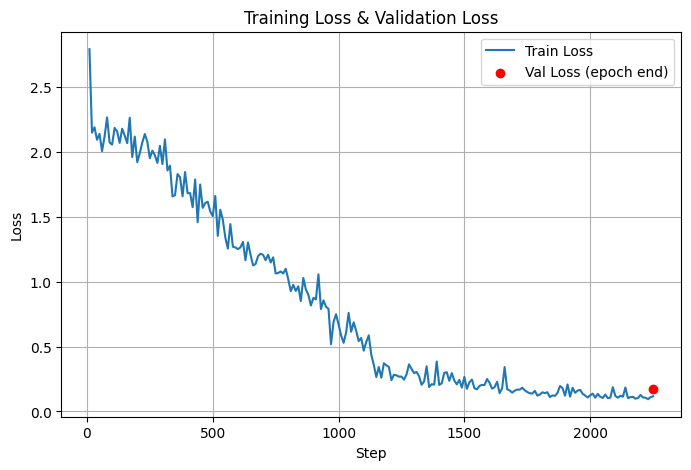

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Lấy log train
history = trainer.state.log_history
train_logs = [x for x in history if "loss" in x and "eval_loss" not in x]
df_train = pd.DataFrame(train_logs)[["step", "loss"]]

# Lấy val loss
val_loss = metrics["eval_loss"]

plt.figure(figsize=(8,5))
plt.plot(df_train["step"], df_train["loss"], label="Train Loss")
plt.scatter([df_train["step"].iloc[-1]], [val_loss], color="red", label="Val Loss (epoch end)")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss & Validation Loss")
plt.grid(True)
plt.legend()
plt.show()


In [21]:
!rm -rf qwen_geo_qa/checkpoint-1125
!rm -f  ziapZ7YW


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
save_dir = "./qwen_geo_qa_final"   # đặt tên gì cũng được

trainer.save_model(save_dir)       # lưu weights model
tokenizer.save_pretrained(save_dir)  # lưu tokenizer + chat_template


('./qwen_geo_qa_final/tokenizer_config.json',
 './qwen_geo_qa_final/special_tokens_map.json',
 './qwen_geo_qa_final/chat_template.jinja',
 './qwen_geo_qa_final/vocab.json',
 './qwen_geo_qa_final/merges.txt',
 './qwen_geo_qa_final/added_tokens.json',
 './qwen_geo_qa_final/tokenizer.json')

In [ ]:
!zip -r qwen_geo_qa_checkpoint.zip qwen_geo_qa


# *Fine-Tune Base+Synthetic*

In [40]:
import json
from datasets import Dataset

synthetic_path = "/kaggle/input/synthetic-dataset/synthetic.json"

with open(synthetic_path, "r", encoding="utf-8") as f:
    synthetic_list = json.load(f)   # top-level là list các sample

# nếu file của bạn là {"data": [...]} thì dùng:
# synthetic_list = json.load(f)["data"]

synthetic_ds = Dataset.from_list(synthetic_list)
print("Số mẫu synthetic:", len(synthetic_ds))


Số mẫu synthetic: 1413


In [41]:
synthetic_clean = clean_dataset(synthetic_ds)
print("Số mẫu synthetic_clean:", len(synthetic_clean))


Map:   0%|          | 0/1413 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1413 [00:00<?, ? examples/s]

Số mẫu synthetic_clean: 1267


In [48]:
import numpy as np
import matplotlib.pyplot as plt

def get_len_list(ds, field, max_samples=None):
    lens = []
    for i, ex in enumerate(ds):
        if max_samples is not None and i >= max_samples:
            break
        txt = ex[field]
        if isinstance(txt, str):
            lens.append(len(txt.split()))   # xấp xỉ số token
    return np.array(lens)

def get_ans_len_list(ds, max_samples=None):
    lens = []
    for i, ex in enumerate(ds):
        if max_samples is not None and i >= max_samples:
            break
        ans = ex["answers"]["text"][0]
        lens.append(len(ans.split()))
    return np.array(lens)

# Synthetic
syn_ctx = get_len_list(synthetic_clean, "context")
syn_q   = get_len_list(synthetic_clean, "question")
syn_a   = get_ans_len_list(synthetic_clean)


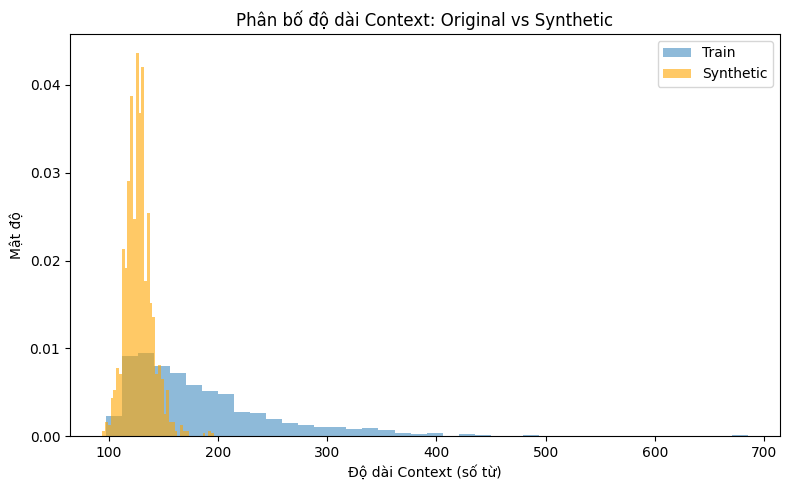

In [52]:
plt.figure(figsize=(8,5))
bins = 40

plt.hist(train_ctx, bins=bins, alpha=0.5, label="Train", density=True)
plt.hist(syn_ctx,   bins=bins, alpha=0.6, label="Synthetic", density=True, color='orange')

plt.xlabel("Độ dài Context (số từ)")
plt.ylabel("Mật độ")
plt.title("Phân bố độ dài Context: Original vs Synthetic")
plt.legend()
plt.tight_layout()
plt.show()


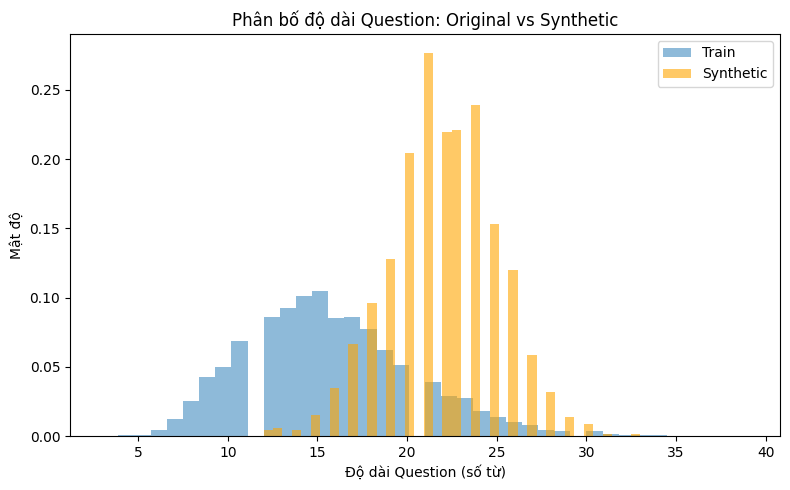

In [53]:
plt.figure(figsize=(8,5))
bins = 40

plt.hist(train_q, bins=bins, alpha=0.5, label="Train", density=True)
plt.hist(syn_q,   bins=bins, alpha=0.6, label="Synthetic", density=True, color='orange')

plt.xlabel("Độ dài Question (số từ)")
plt.ylabel("Mật độ")
plt.title("Phân bố độ dài Question: Original vs Synthetic")
plt.legend()
plt.tight_layout()
plt.show()


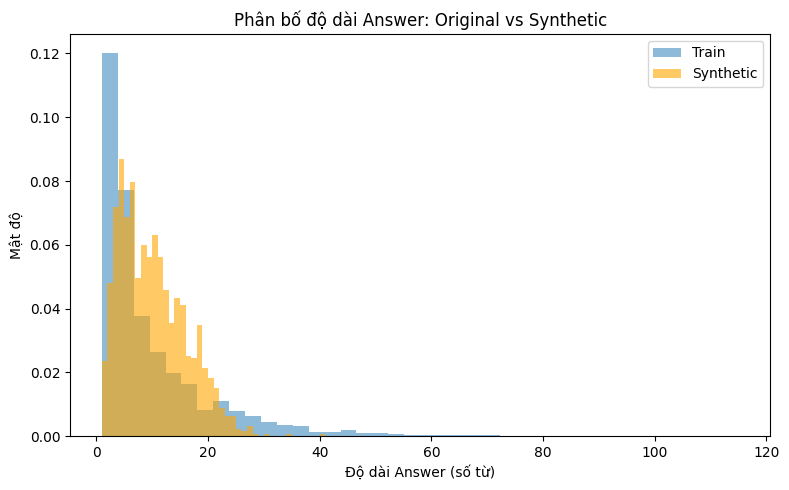

In [54]:
plt.figure(figsize=(8,5))
bins = 40

plt.hist(train_a, bins=bins, alpha=0.5, label="Train", density=True)
plt.hist(syn_a,   bins=bins, alpha=0.6, label="Synthetic", density=True, color='orange')

plt.xlabel("Độ dài Answer (số từ)")
plt.ylabel("Mật độ")
plt.title("Phân bố độ dài Answer: Original vs Synthetic")
plt.legend()
plt.tight_layout()
plt.show()


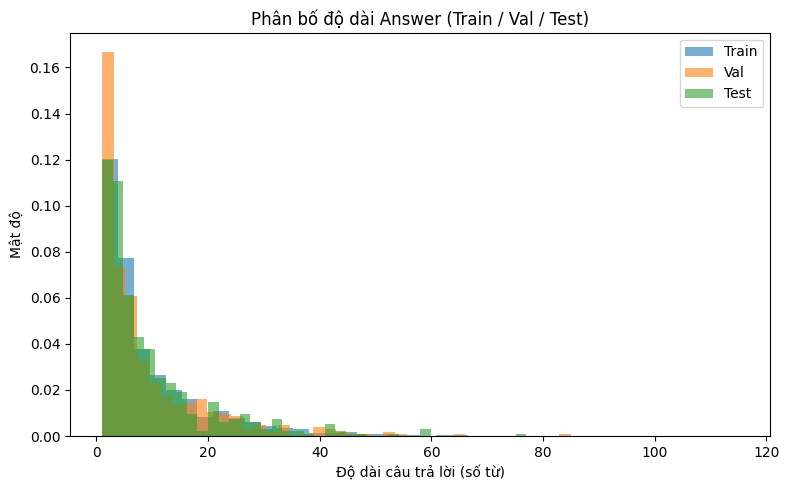

In [46]:
plt.figure(figsize=(8,5))
bins = 40

plt.hist(train_a, bins=bins, alpha=0.6, label="Train", density=True)
plt.hist(val_a,   bins=bins, alpha=0.6, label="Val",   density=True)
plt.hist(test_a,  bins=bins, alpha=0.6, label="Test",  density=True)

plt.xlabel("Độ dài câu trả lời (số từ)")
plt.ylabel("Mật độ")
plt.title("Phân bố độ dài Answer (Train / Val / Test)")
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd
from datasets import Dataset, DatasetDict

# 1) convert sang pandas
df_train = train_clean.to_pandas()
df_synth = synthetic_clean.to_pandas()

# 2) ghép lại
df_merged = pd.concat([df_train, df_synth], ignore_index=True)

# 3) tạo lại Dataset cho train
train_merged = Dataset.from_pandas(df_merged, preserve_index=False)

print("Số mẫu train_merged:", len(train_merged))

# 4) gom vào DatasetDict để dùng sau
datasets_all = DatasetDict({
    "train": train_merged,
    "validation": val_clean,
    "test": test_clean,
})


Số mẫu train_merged: 5767


In [12]:
# ===============================
# 🟦 Cell Load model & tokenizer
# ===============================
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "Qwen/Qwen3-0.6B"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",   # để mặc định fp32
)

# Qwen thường thiếu pad_token → dùng eos_token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

tokenizer.padding_side = "right"
model.config.pad_token_id = tokenizer.pad_token_id

print("✅ Loaded Qwen3-0.6B (FP32, no AMP)")


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

2025-11-30 03:18:04.327413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764472684.734727      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764472684.866657      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

✅ Loaded Qwen3-0.6B (FP32, no AMP)


In [13]:
# Hàm lấy answer dùng chung cho cả ViQuAD và synthetic
def get_answer_text(example):
    # ViQuAD: answers["text"][0]
    if "answers" in example and "text" in example["answers"]:
        texts = example["answers"]["text"]
        if len(texts) > 0 and texts[0].strip():
            return texts[0]
    # Synthetic: field "answer"
    if "answer" in example and example["answer"]:
        return example["answer"]
    return ""

# Build text dạng chat (giống run base)
def make_chat_text_synth(example):
    context  = example["context"]
    question = example["question"]
    answer   = get_answer_text(example)

    system_msg = (
        "Bạn là trợ lý AI tiếng Việt, nhiệm vụ là trả lời câu hỏi "
        "dựa trên đoạn văn được cung cấp, ưu tiên trích đúng cụm từ trong đoạn."
    )

    user_msg = (
        "Đọc đoạn văn sau và trả lời câu hỏi.\n\n"
        f"Đoạn văn:\n{context}\n\n"
        f"Câu hỏi: {question}"
    )

    messages = [
        {"role": "system",    "content": system_msg},
        {"role": "user",      "content": user_msg},
        {"role": "assistant", "content": answer},
    ]

    # dùng chat_template của Qwen giống bên base
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=False,
    )
    return {"text": text}

# Áp dụng cho train / val (và test nếu bạn muốn lấy text luôn)
train_sft = datasets_all["train"].map(
    make_chat_text_synth,
    remove_columns=datasets_all["train"].column_names,
)

val_sft = datasets_all["validation"].map(
    make_chat_text_synth,
    remove_columns=datasets_all["validation"].column_names,
)

print(train_sft[0]["text"][:400])


Map:   0%|          | 0/5767 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

<|im_start|>system
Bạn là trợ lý AI tiếng Việt, nhiệm vụ là trả lời câu hỏi dựa trên đoạn văn được cung cấp, ưu tiên trích đúng cụm từ trong đoạn.<|im_end|>
<|im_start|>user
Đọc đoạn văn sau và trả lời câu hỏi.

Đoạn văn:
Sau đó vài ngày, Báo Cứu quốc coi bản ghi nhớ ngày 24/11/1945 là sự xác nhận một chính phủ liên hiệp đã tồn tại. Việt Quốc lên án việc này. Hồ Chí Minh thông báo cho Nguyễn Hải T


In [20]:
from trl import SFTConfig

args = SFTConfig(
    output_dir="./qwen_geo_qa_synth",
    num_train_epochs=2,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=2,
    learning_rate=2e-4,
    warmup_ratio=0.03,
    logging_strategy="steps",
    logging_steps=10,
    save_strategy="epoch",
    optim="adamw_torch",
    max_seq_length=1024,
    report_to="none",
    gradient_checkpointing=True,
)

In [22]:
from trl import SFTTrainer

trainer2 = SFTTrainer(
    model=model,
    args=args,
    train_dataset=train_sft,
    eval_dataset=val_sft,
    tokenizer=tokenizer,
    dataset_text_field="text",
)

Map:   0%|          | 0/5767 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [23]:
# ============================================
# 🚀 Cell 4 – Fine-tune lần 2 (base + synthetic)
# ============================================
trainer2.train()

Step,Training Loss
10,2.225000
20,2.276700
30,2.176600
40,2.261600
50,2.346800
60,2.329300
70,2.508300
80,2.621300
90,2.570600
100,2.754200


TrainOutput(global_step=2884, training_loss=1.104692280995201, metrics={'train_runtime': 7677.6501, 'train_samples_per_second': 1.502, 'train_steps_per_second': 0.376, 'total_flos': 1.189431270703104e+16, 'train_loss': 1.104692280995201, 'epoch': 2.0})

In [24]:
!rm -rf qwen_geo_qa_synth/checkpoint-1442

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [25]:
# 🔥 Save final model
save_dir = "/kaggle/working/qwen_geo_qa_synth_final"  # bạn đổi tên tùy ý

trainer2.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

print("Saved final model to:", save_dir)


Saved final model to: /kaggle/working/qwen_geo_qa_synth_final


In [26]:
# ============================================
# 2. Nén toàn bộ thư mục qwen_geo_qa_mixed
# ============================================
import shutil
import os

ARCHIVE_DIR = "./qwen_geo_qa_synth_final"
output_zip_name = "qwen_mixed_complete_archive.zip"

print(f"Đang nén toàn bộ thư mục: {ARCHIVE_DIR}")

shutil.make_archive(
    base_name=output_zip_name.replace(".zip", ""),
    format='zip',
    root_dir=os.path.dirname(ARCHIVE_DIR), # /kaggle/working
    base_dir=os.path.basename(ARCHIVE_DIR) # qwen_geo_qa_mixed
)
print(f"✅ Đã tạo file ZIP thành công: {output_zip_name}")

Đang nén toàn bộ thư mục: ./qwen_geo_qa_synth_final
✅ Đã tạo file ZIP thành công: qwen_mixed_complete_archive.zip


# **Đánh giá**

In [11]:
!pip install -U "transformers>=4.53.0" "accelerate>=0.34.0" --quiet

import transformers, torch
print("Transformers version:", transformers.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Transformers version: 4.57.3
Device: cuda


In [9]:
import shutil

# Copy base model
shutil.copytree(
    "/kaggle/input/qwen-base-final/qwen_geo_qa_final",
    "/kaggle/working/qwen_geo_qa_final",
    dirs_exist_ok=True
)

# Copy synth model
shutil.copytree(
    "/kaggle/input/qwen-synth-final/qwen_geo_qa_synth_final",
    "/kaggle/working/qwen_geo_qa_synth_final",
    dirs_exist_ok=True
)

print("✔️ Copied both models into working directory.")


✔️ Copied both models into working directory.


In [12]:
from transformers import AutoTokenizer, AutoModelForCausalLM

def load_model(path):
    tokenizer = AutoTokenizer.from_pretrained(
        path,
        trust_remote_code=True,
    )
    model = AutoModelForCausalLM.from_pretrained(
        path,
        trust_remote_code=True,
    ).to(device)
    model.eval()
    return tokenizer, model

tok_base,  model_base  = load_model("/kaggle/working/qwen_geo_qa_final")
tok_synth, model_synth = load_model("/kaggle/working/qwen_geo_qa_synth_final")

print("✔️ Loaded both models successfully.")


The tokenizer you are loading from '/kaggle/working/qwen_geo_qa_final' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
The tokenizer you are loading from '/kaggle/working/qwen_geo_qa_synth_final' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


✔️ Loaded both models successfully.


In [19]:
import re
import torch

def build_chat_prompt(tokenizer, context, question):
    system_msg = (
        "Bạn là trợ lý AI tiếng Việt, nhiệm vụ là trả lời câu hỏi dựa trên đoạn văn. "
        "Cố gắng trích đúng cụm từ xuất hiện trong đoạn văn."
    )
    user_msg = (
        f"Đoạn văn:\n{context}\n\n"
        f"Câu hỏi: {question}"
    )

    # giờ hàm này trả về MESSAGES, không trả về STRING nữa
    messages = [
        {"role": "system", "content": system_msg},
        {"role": "user",   "content": user_msg},
    ]
    return messages


@torch.no_grad()
def generate_answer(model, tok, context, question, max_new_tokens=80):
    # 1) Lấy messages
    messages = build_chat_prompt(tok, context, question)

    # 2) Để tokenizer tự build input_ids bằng chat_template
    inputs = tok.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(device)

    # 3) Generate
    outputs = model.generate(
        inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        pad_token_id=tok.eos_token_id
    )

    # 4) CẮT bỏ phần prompt, chỉ giữ token mà model sinh thêm
    gen_ids = outputs[0, inputs.shape[-1]:]

    text = tok.decode(gen_ids, skip_special_tokens=True).strip()

    # 5) Xoá đoạn <think>...</think> nếu có
    text = re.sub(r"<think>.*?</think>", "", text, flags=re.DOTALL).strip()

    return text


In [15]:
!pip install evaluate datasets sacrebleu rouge-score --quiet

import evaluate
import numpy as np
from tqdm.auto import tqdm
import re

# Load metrics
bleu_metric = evaluate.load("bleu")
meteor_metric = evaluate.load("meteor")
rouge_metric = evaluate.load("rouge")


def normalize(text):
    return re.sub(r"\s+", " ", text.lower().strip())

def exact_match(pred, gold):
    return 1.0 if normalize(pred) == normalize(gold) else 0.0

def f1(pred, gold):
    p = normalize(pred).split()
    g = normalize(gold).split()
    if not p or not g:
        return 0.0
    inter = set(p) & set(g)
    if not inter:
        return 0.0
    precision = len(inter) / len(p)
    recall    = len(inter) / len(g)
    return 2 * precision * recall / (precision + recall)


def evaluate_full(model, tok, dataset):
    preds, refs = [], []
    EMs, F1s = [], []

    for ex in tqdm(dataset):
        ctx = ex["context"]
        ques = ex["question"]
        gold = ex["answers"]["text"][0]

        pred = generate_answer(model, tok, ctx, ques)

        # normalize answers
        pred_norm = normalize(pred)
        gold_norm = normalize(gold)

        preds.append(pred_norm)
        refs.append(gold_norm)

        EMs.append(exact_match(pred_norm, gold_norm))
        F1s.append(f1(pred_norm, gold_norm))

    # BLEU expects list of list of refs
    bleu = bleu_metric.compute(predictions=preds, references=[[r] for r in refs])["bleu"]

    meteor = meteor_metric.compute(predictions=preds, references=refs)["meteor"]

    rouge_scores = rouge_metric.compute(predictions=preds, references=refs)

    return {
        "EM": np.mean(EMs),
        "F1": np.mean(F1s),
        "BLEU-4": bleu,
        "ROUGE-1": rouge_scores["rouge1"],
        "ROUGE-2": rouge_scores["rouge2"],
        "ROUGE-L": rouge_scores["rougeL"],
        "METEOR": meteor,
    }


print("🔍 Đang đánh giá model Base...")
base_scores = evaluate_full(model_base, tok_base, test_clean)

print("🔍 Đang đánh giá model Synthetic...")
synth_scores = evaluate_full(model_synth, tok_synth, test_clean)

base_scores, synth_scores


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


🔍 Đang đánh giá model Base...


  0%|          | 0/500 [00:00<?, ?it/s]

🔍 Đang đánh giá model Synthetic...


  0%|          | 0/500 [00:00<?, ?it/s]

({'EM': 0.382,
  'F1': 0.6059813361861512,
  'BLEU-4': 0.5716998570117203,
  'ROUGE-1': 0.6803254644502956,
  'ROUGE-2': 0.5751364884483008,
  'ROUGE-L': 0.6637796709842904,
  'METEOR': 0.5916055981102837},
 {'EM': 0.292,
  'F1': 0.5000294485574042,
  'BLEU-4': 0.41825039646025836,
  'ROUGE-1': 0.5806038336810411,
  'ROUGE-2': 0.4643443013453772,
  'ROUGE-L': 0.5571240203153998,
  'METEOR': 0.4802233362229862})

In [16]:
import pandas as pd

metrics = ["EM", "F1", "BLEU-4", "ROUGE-1", "ROUGE-2", "ROUGE-L", "METEOR"]

rows = []
for m in metrics:
    base_val  = base_scores[m] * 100
    synth_val = synth_scores[m] * 100
    delta     = synth_val - base_val
    arrow = "↑" if delta > 0 else "↓"
    rows.append([m, f"{base_val:.2f}%", f"{synth_val:.2f}%", f"{arrow} {abs(delta):.2f}%"])

df = pd.DataFrame(rows, columns=["Metric", "Baseline (Original)", "Synthetic (Augmented)", "Δ (Aug - Base)"])
df


,Metric,Baseline (Original),Synthetic (Augmented),Δ (Aug - Base)
0,EM,38.20%,29.20%,↓ 9.00%
1,F1,60.60%,50.00%,↓ 10.60%
2,BLEU-4,57.17%,41.83%,↓ 15.34%
3,ROUGE-1,68.03%,58.06%,↓ 9.97%
4,ROUGE-2,57.51%,46.43%,↓ 11.08%
5,ROUGE-L,66.38%,55.71%,↓ 10.67%
6,METEOR,59.16%,48.02%,↓ 11.14%


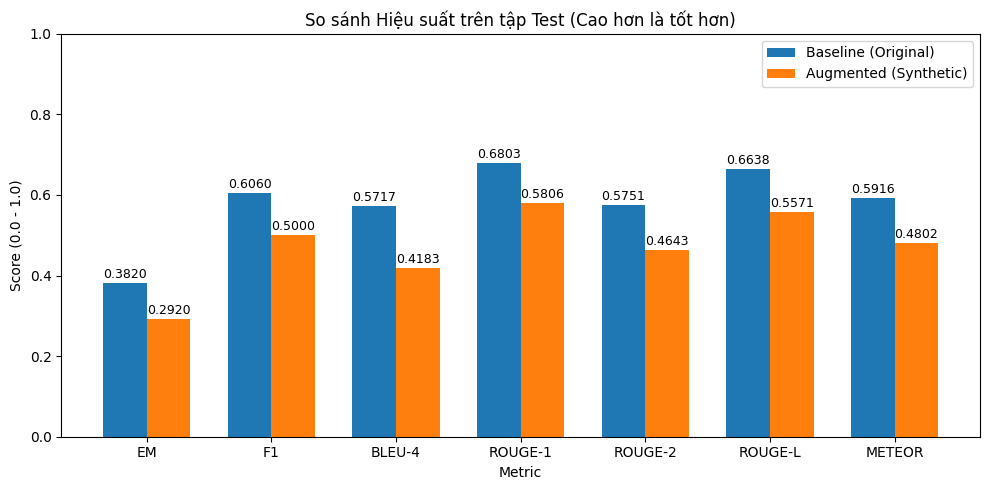

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# ====== 1. Nhập số liệu (dạng 0–1) ======
metrics = ["EM", "F1", "BLEU-4", "ROUGE-1", "ROUGE-2", "ROUGE-L", "METEOR"]

baseline_scores = np.array([0.3820, 0.6060, 0.5717, 0.6803, 0.5751, 0.6638, 0.5916])
augmented_scores = np.array([0.2920, 0.5000, 0.4183, 0.5806, 0.4643, 0.5571, 0.4802])

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))

bars1 = ax.bar(x - width/2, baseline_scores, width, label="Baseline (Original)")
bars2 = ax.bar(x + width/2, augmented_scores, width, label="Augmented (Synthetic)")

ax.set_ylim(0, 1.0)
ax.set_ylabel("Score (0.0 - 1.0)")
ax.set_xlabel("Metric")
ax.set_title("So sánh Hiệu suất trên tập Test (Cao hơn là tốt hơn)")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Ghi số lên trên mỗi cột
def add_labels(bars):
    for b in bars:
        height = b.get_height()
        ax.text(
            b.get_x() + b.get_width() / 2,
            height + 0.005,
            f"{height:.4f}",
            ha="center",
            va="bottom",
            fontsize=9
        )

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()


In [17]:
import random

def show_example(idx, model, tok, dataset):
    ex = dataset[idx]
    ctx = ex["context"]
    ques = ex["question"]
    gold = ex["answers"]["text"][0]
    pred = generate_answer(model, tok, ctx, ques)

    print("==== Ví dụ", idx, "====")
    print("Context:", ctx[:300], "...\n")
    print("Question:", ques)
    print("Gold:", gold)
    print("Pred:", pred)
    print("F1:", f1(pred, gold))
    print("EM:", exact_match(pred, gold))

# xem vài ví dụ cho cả 2 model
for i in random.sample(range(len(test_clean)), 5):
    show_example(i, model_base, tok_base, test_clean)
    print("\n---\n")
    show_example(i, model_synth, tok_synth, test_clean)
    print("="*8, "\n")


==== Ví dụ 91 ====
Context: Hai Tuyến A và B hiện tại giao nhau ở nhà ga Roma Termini. Một nhánh mới của Tuyến B (B1) đang được xây dựng với chi phí ước tính là 500 triệu euro, dự kiến khai trương vào năm 2012. B1 sẽ kết nối với B tại Quảng trường Bologna và sẽ có bốn trạm phân bố trong 3,9 km (2 dặm). Tuyến C là tuyến thứ ba, ...

Question: Theo dự kiến ban đầu, tuyến D có khoảng bao nhiêu nhà ga?
Gold: 22 nhà ga
Pred: 22 nhà ga
F1: 1.0
EM: 1.0

---

==== Ví dụ 91 ====
Context: Hai Tuyến A và B hiện tại giao nhau ở nhà ga Roma Termini. Một nhánh mới của Tuyến B (B1) đang được xây dựng với chi phí ước tính là 500 triệu euro, dự kiến khai trương vào năm 2012. B1 sẽ kết nối với B tại Quảng trường Bologna và sẽ có bốn trạm phân bố trong 3,9 km (2 dặm). Tuyến C là tuyến thứ ba, ...

Question: Theo dự kiến ban đầu, tuyến D có khoảng bao nhiêu nhà ga?
Gold: 22 nhà ga
Pred: 22 nhà ga phân bố trên một khoảng cách 20 km (12 dặm)
F1: 0.375
EM: 0.0

==== Ví dụ 131 ====
Context: Sau cuộc Nội chiến

# **ĐÁNH GIÁ LLM**

In [29]:
!pip install groq

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.3/137.3 kB 3.9 MB/s eta 0:00:00


In [ ]:
from groq import Groq

client = Groq(api_key="YOUR_API_KEY_HERE")

def build_judge_prompt_score(context, question, gold, pred):
    return f"""
Bạn là trọng tài AI. Hãy chấm câu trả lời theo thang điểm 0–5.

Context:
\"\"\"{context}\"\"\"

Câu hỏi: {question}

Đáp án chuẩn: {gold}

Câu trả lời của model: {pred}

Yêu cầu:
- 5: Hoàn toàn đúng và trích dẫn chính xác
- 4: Đúng phần lớn, chỉ sai/thiếu chút
- 3: Khá đúng nhưng thiếu nhiều ý quan trọng
- 2: Sai đáng kể nhưng có liên quan
- 1: Hầu như sai
- 0: Hoàn toàn sai hoặc không liên quan

Chỉ trả về một số duy nhất (0–5).
"""

def groq_judge(prompt):
    res = client.chat.completions.create(
        model="llama-3.3-70b-versatile",
        messages=[{"role":"user","content":prompt}],
        temperature=0
    )
    out = res.choices[0].message.content.strip()

    # lấy số trong output
    try:
        num = float(out.split()[0])
        if 0 <= num <= 5:
            return num
    except:
        pass
    return 0.0


In [33]:
ctx = "Việt Nam nằm ở Đông Nam Á."
q = "Việt Nam thuộc khu vực nào?"
gold = "Đông Nam Á"
pred = "Đông Nam Á"

prompt = build_judge_prompt_score(ctx, q, gold, pred)

print("Judge score =", groq_judge(prompt))


Judge score = 5.0


In [34]:
import random
from tqdm.auto import tqdm

def llm_eval_with_groq(model, tokenizer, dataset, max_samples=100):
    idxs = random.sample(range(len(dataset)), max_samples)
    scores = []

    for i in tqdm(idxs):
        ex = dataset[i]
        ctx = ex["context"]
        q   = ex["question"]
        gold = ex["answers"]["text"][0]

        pred = generate_answer(model, tokenizer, ctx, q)

        prompt = build_judge_prompt_score(ctx, q, gold, pred)
        score = groq_judge(prompt)

        scores.append(score)

    return sum(scores)/len(scores), scores


In [35]:
num_samples = 50   # hoặc 100 nếu muốn

base_score, base_list = llm_eval_with_groq(model_base, tok_base, test_clean, num_samples)
mixed_score, mixed_list = llm_eval_with_groq(model_synth, tok_synth, test_clean, num_samples)

print("===== GROQ LLM JUDGE RESULT =====")
print("Số mẫu:", num_samples)
print("Điểm trung bình Base :", base_score)
print("Điểm trung bình Mixed:", mixed_score)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

===== GROQ LLM JUDGE RESULT =====
Số mẫu: 50
Điểm trung bình Base : 3.66
Điểm trung bình Mixed: 3.16


In [36]:
def compare_winloss(base_scores, mixed_scores):
    base_win = 0
    mixed_win = 0
    draw = 0

    for b, m in zip(base_scores, mixed_scores):
        if abs(b - m) < 1e-6:
            draw += 1
        elif b > m:
            base_win += 1
        else:
            mixed_win += 1

    return base_win, mixed_win, draw


In [37]:
bw, mw, dr = compare_winloss(base_list, mixed_list)

print("\n===== GROQ HEAD-TO-HEAD =====")
print("Base thắng :", bw)
print("Mixed thắng:", mw)
print("Hòa       :", dr)



===== GROQ HEAD-TO-HEAD =====
Base thắng : 20
Mixed thắng: 13
Hòa       : 17


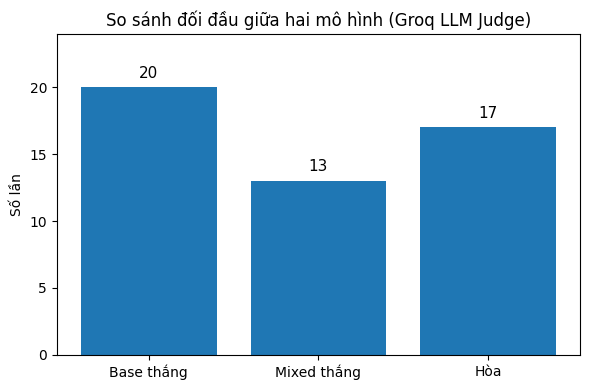

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Nếu chưa có thì tính lại:
# bw, mw, dr = compare_winloss(base_list, mixed_list)

labels = ["Base thắng", "Mixed thắng", "Hòa"]
values = [bw, mw, dr]

plt.figure(figsize=(6,4))
bars = plt.bar(labels, values)

# Ghi số lên trên từng cột
for bar, val in zip(bars, values):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.5,
        str(val),
        ha="center",
        va="bottom",
        fontsize=11
    )

plt.ylabel("Số lần")
plt.title("So sánh đối đầu giữa hai mô hình (Groq LLM Judge)")
plt.ylim(0, max(values)*1.2)

plt.tight_layout()
plt.show()
